In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as sps
from scipy.signal import fftconvolve
from IPython.display import Image

In [3]:
# Read in the data
data = pd.read_csv("data/data.csv")
time = data.time 
counters = data.columns[1:]
data.head()

time  counter_1.1  counter_1.2  counter_2  \
0  2016-09-19 02:00:00.000 +0200         20.0          0.0         60   
1  2016-09-19 02:03:00.000 +0200         20.0          0.0         80   
2  2016-09-19 02:06:00.000 +0200          0.0          0.0         20   
3  2016-09-19 02:09:00.000 +0200         20.0          0.0         60   
4  2016-09-19 02:12:00.000 +0200         80.0         20.0         80   

   counter_3.1  counter_3.2  counter_4.1  counter_4.2  counter_5.1  \
0          0.0         20.0           20            0            0   
1         40.0         60.0           60           40            0   
2         20.0         20.0           40           20           20   
3         20.0         20.0           40            0           40   
4         80.0          0.0           80            0           20   

   counter_5.2  ...  counter_8.2  counter_9.1  counter_9.2  counter_10.1  \
0           20  ...           20           20            0             0   
1           20  ...           20           20            0             0   
2           20  ...           20           40            0             0   
3            0  ...            0            0            0             0   
4            0  ...            0           40           20            20   

   counter_10.2  counter_10.3  counter_11  counter_12  counter_13.1  \
0             0             0           0           0          40.0   
1            20            40           0           0          40.0   
2            20             0           0           0          20.0   
3             0             0           0           0           0.0   
4            20             0           0           0          60.0   

   counter_13.2  
0          20.0  
1          20.0  
2          20.0  
3           0.0  
4           0.0  

[5 rows x 25 columns]

In [4]:
def predict_flow(input, delay):
    """ 
    Input: 
        input: data from a certain counter
        delay: amount of time steps needed to get to second location
    Output:
        The predicted flow at the second location
    """

    if delay == 0:
        return input

    # divide the area of a gaussian distribution into n parts
    n = 2 * delay+1
    gaussian = np.array([sps.comb(n - 1, i, exact=True) for i in range(n)], dtype='O')
    gaussian = np.float64(gaussian)/np.float64(gaussian).sum()
    
    # convolve the input data with the gaussian weights
    output = fftconvolve(input, gaussian)
    output = np.convolve(input, gaussian)

    return output[:-2*delay]

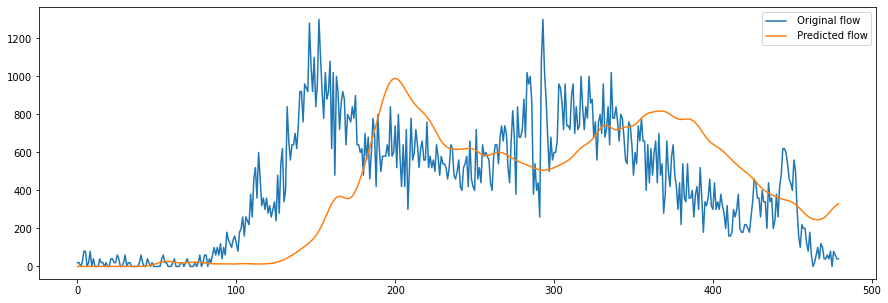

In [8]:
# take data from a single day of counter_1.1
data_one_day = data[0:480]
estimated_flow = predict_flow(data_one_day["counter_1.1"], delay=50)

# plot original and predicted flow
plt.figure(figsize=(15,5))
plt.plot(data_one_day["counter_1.1"], label = ' Original flow')
plt.plot(estimated_flow, label = ' Predicted flow')
plt.legend()
plt.show()

We now consider a real example

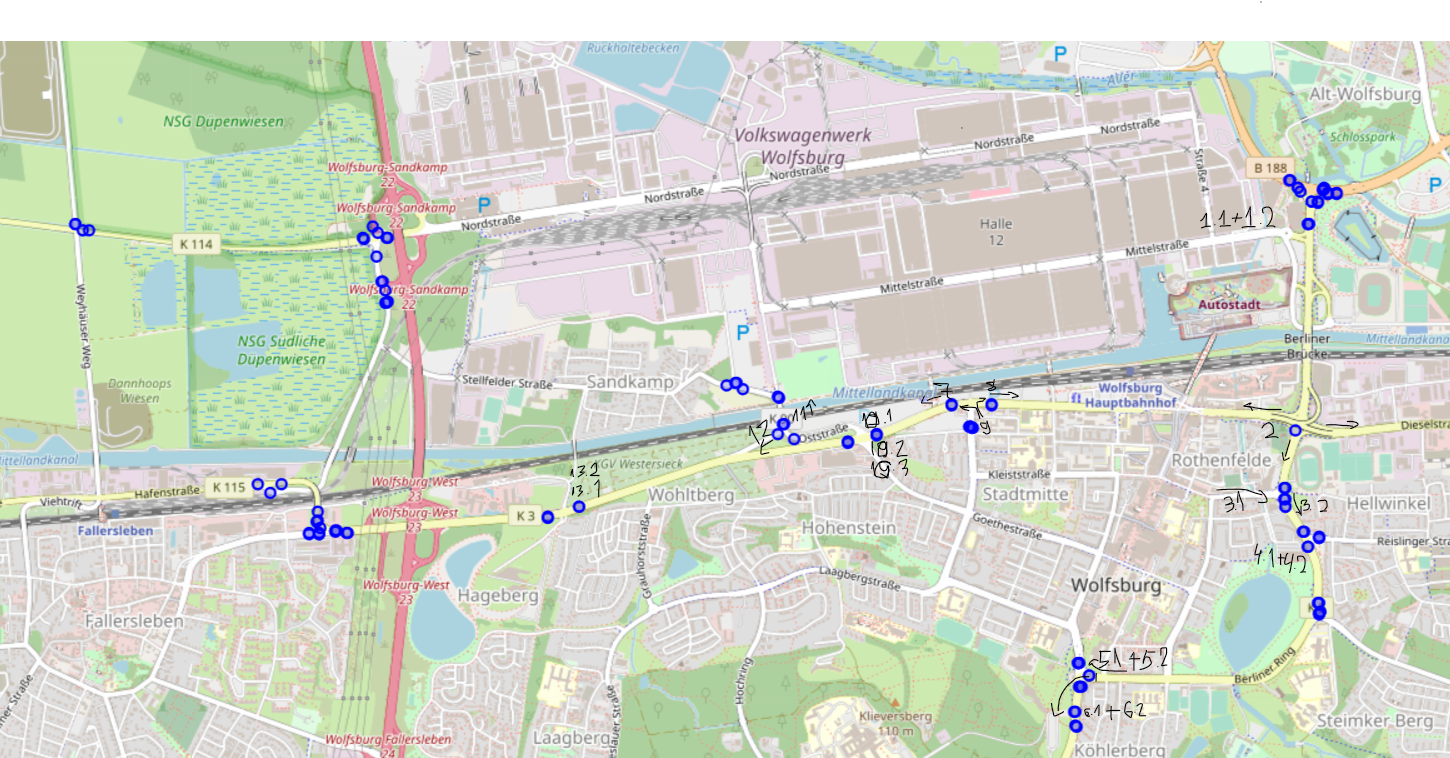

In [13]:
Image('figures/map.png')

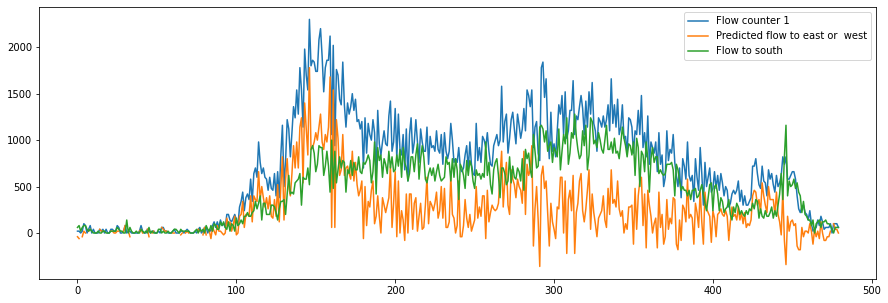

In [15]:
# take data from counters 1.1 + 1.2 & counter_2
counter_1 = data_one_day["counter_1.1"] + data_one_day["counter_1.2"]
counter_2 = data_one_day["counter_2"]

#true data from counter 7 subtracting the new arrivals from counter 9
counter_7 = data_one_day["counter_7.1"] + data_one_day["counter_7.2"] - data_one_day["counter_9.1"]

# compute the proportion of counter_1 going west
# it takes around 3 min to get to counter 7 from counter 1, so delay is 1 time steps
P1 = np.diag(counter_7 / predict_flow(counter_1, delay=1))

# it takes 2 min to get from counter_1 to counter_2
# compute proportion of counter_1 going south
P2 = np.diag(counter_2 / predict_flow(counter_1, delay=0))

# compute proportion of counter 1 going east + west
predicted_flow_east_or_west = np.dot((np.eye(480) - P2), predict_flow(counter_1, delay=0))

plt.figure(figsize=(15,5))
plt.plot(counter_1, label='Flow counter 1')
plt.plot(predicted_flow_east_or_west, label = 'Predicted flow to east or  west') 
plt.plot(counter_2, label = 'Flow to south') 
plt.legend()
plt.show()      

We now look at counter 5. We want to estimate the flow going north just before counter 5, given that we now the flow at counter 4.

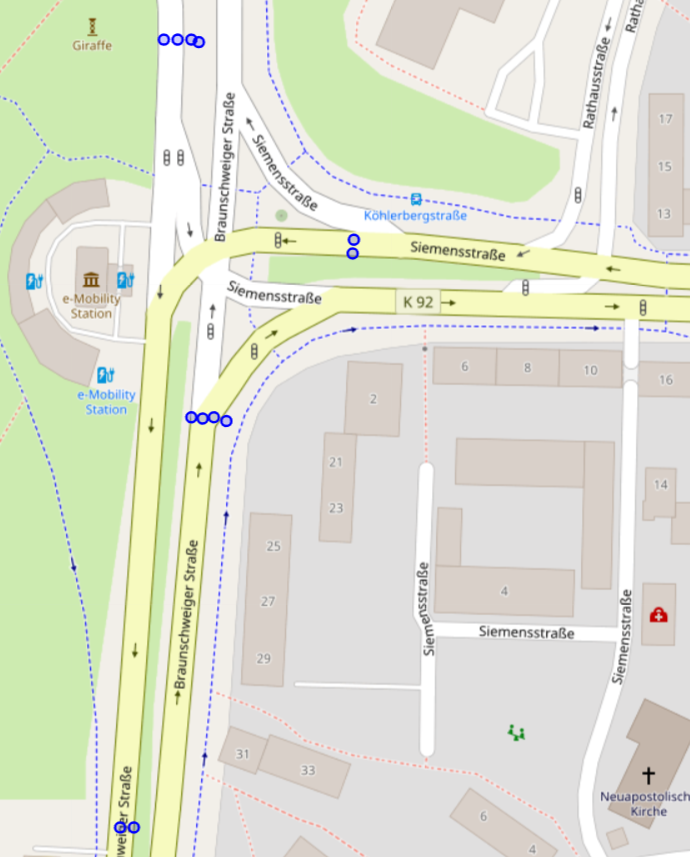

In [18]:
Image('figures/image2.png', height = 500)

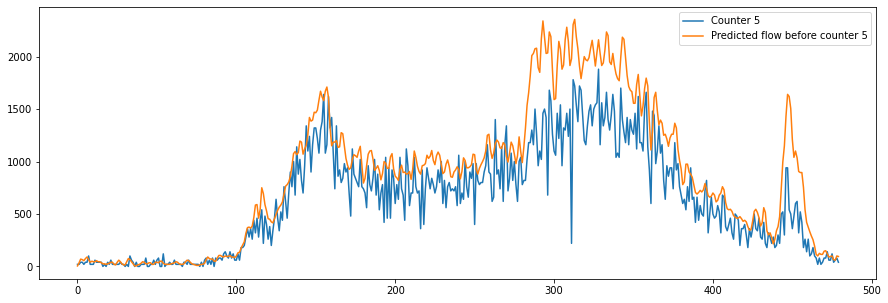

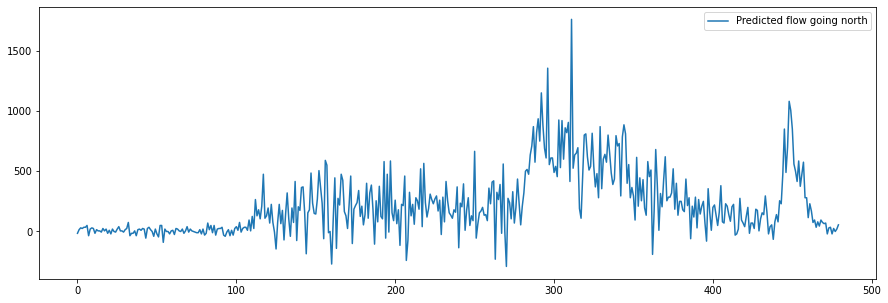

In [19]:
# counter 4 flow
counter_4 = data_one_day["counter_4.1"] + data_one_day["counter_4.2"]

# counter 5 data
counter_5 = data_one_day["counter_5.1"] + data_one_day["counter_5.2"]

# predict dataflow just before counter 5
predicted_flow_before_5 = predict_flow(counter_4, delay=1)

plt.figure(figsize=(15,5))
plt.plot(counter_5, label='Counter 5')
plt.plot(predicted_flow_before_5, label = 'Predicted flow before counter 5')
plt.legend()
plt.show()

# plot predicted flow going north
predicted_flow_north = predicted_flow_before_5 - counter_5
plt.figure(figsize=(15,5))
plt.plot(predicted_flow_north, label = 'Predicted flow going north')
plt.legend()
plt.show()

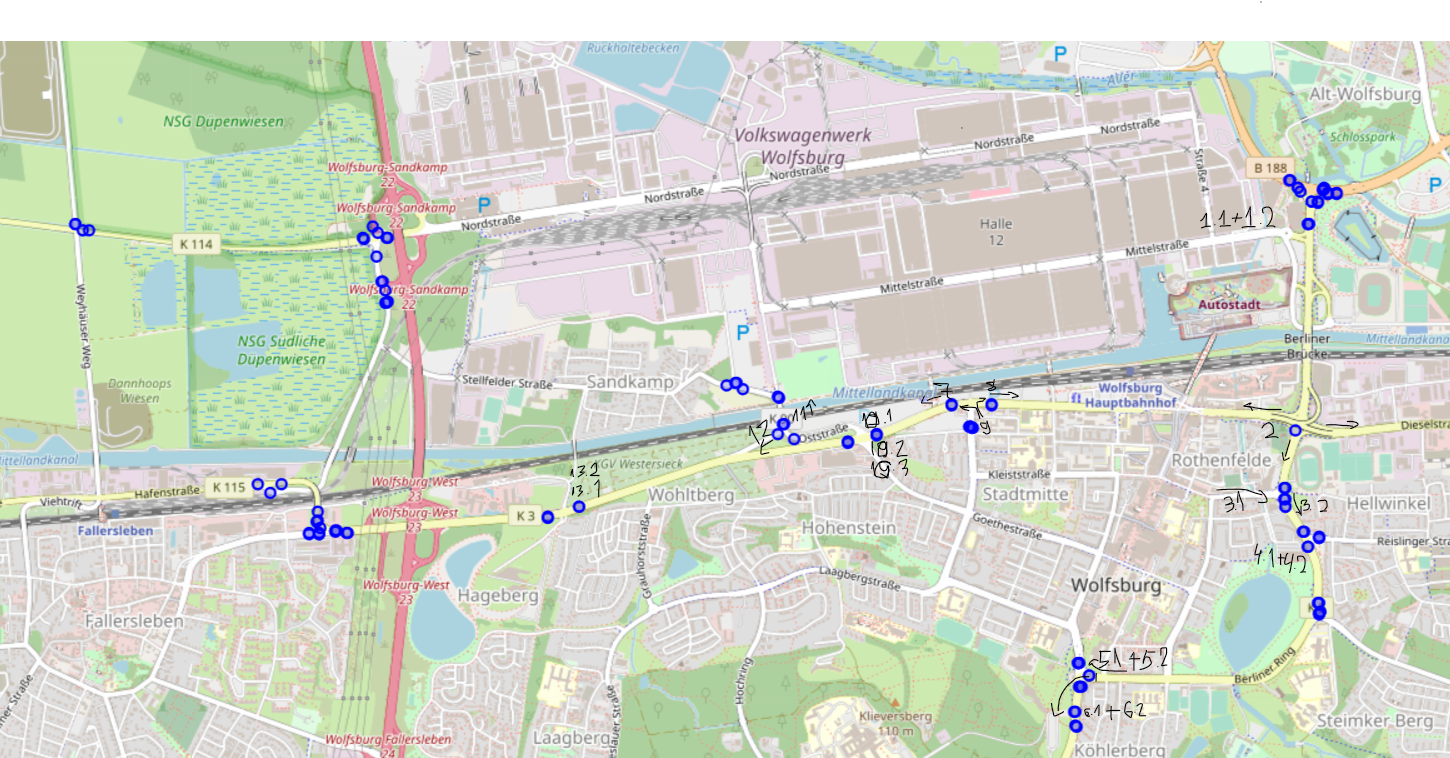

In [20]:
Image('figures/map.png')

It takes 9 minutes to go from counter 1 to counter 13

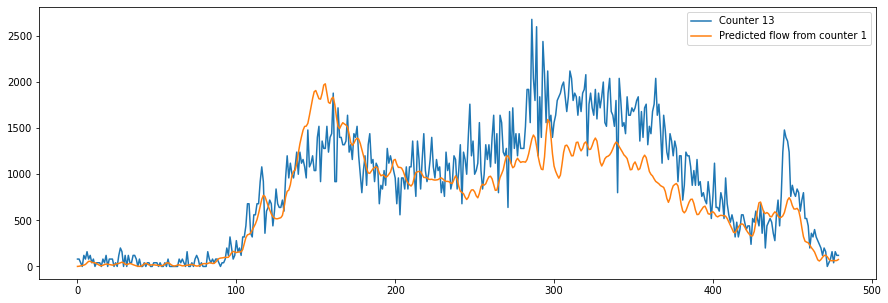

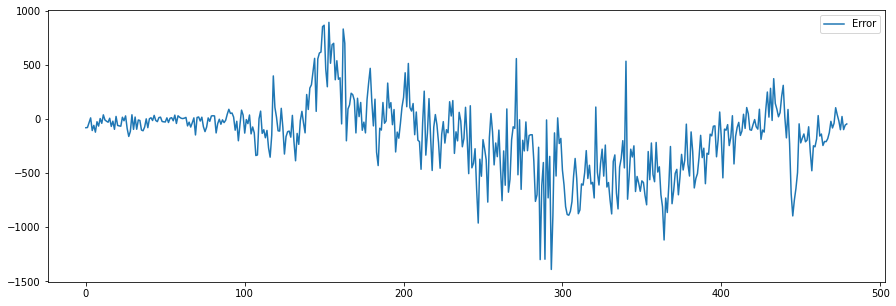

In [21]:
# counter 13
counter_13 = data_one_day["counter_13.1"] + data_one_day["counter_13.1"]

# predict fow from counter 1 after 9 min
predicted_flow = predict_flow(counter_1, delay=3)


plt.figure(figsize=(15,5))
plt.plot(counter_13, label='Counter 13')
plt.plot(predicted_flow, label='Predicted flow from counter 1')
plt.legend()
plt.show()

# plot difference
plt.figure(figsize=(15,5))
plt.plot(predicted_flow - counter_13, label='Error')
plt.legend()
plt.show()

In an urban setting, we commony have mor interetions. Suppose we have counters X_1, X_2, ..., X_n and from each we can reach each of the counters Y_1, ..., Y_m. Given the data from both counters, we would like to estimate the probabilities of going from X_i to Y_j. In the cities the times from X_i to Y_j are usually very short, and the data we have is mostly within an hour, so we assume that all cars arrive with a constant delay.

In [22]:
def simulate_y(X, m, p, delays):
    """
    Input:
    X = [X_(1,t), X_(2,t), X_(3,t), ..., X_(n,t)]

    p: p_(ij), mxn, is the probability to go from X_j to Y_i
      = [[p_(11), p_(12), ..., p_(1n)],
        [p_(21), p_(22), ..., p_(2n)],
        ...
        [p_(m1), p_(m2), ..., p_(mn)]]

    delays: d_(ij), mxn, is number of time steps to reach Y_i from X_j
      = [[d_(11), d_(12), ..., d_(1n)],
        [d_(21), d_(22), ..., d_(2n)],
        ...
        [d_(m1), d_(m2), ..., d_(mn)]]
    
    Output:
    Y_hat = [Y_hat_(1,t), Y_hat_(2,t), ..., Y_hat_(m,t)],
    where Y_hat_(i, t) = np.dot(p[i], [X_(1,t-d_(i1)), X_(2,t-d_(i2)), ..., X_(n,t-d_(in))])
    """

    X = np.array([X])
    n = len(X)

    t = len(X[0])
    
    Y = np.zeros((m, t))

    for i in range(m):
        for j in range(t):
            for k in range(n):

              Y[i][j] += p[i][k] * X[k][j - delays[i][k]]
              

    return Y

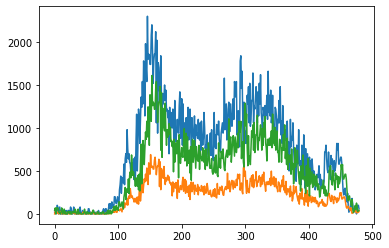

In [23]:
Y = simulate_y(X=counter_1,
               m=2,
               p=[[0.3], [0.7]],
               delays=[[5],[7]])

plt.plot(counter_1)
plt.plot(Y[0])
plt.plot(Y[1])
plt.show()

In [24]:
def optimise_probabilities(Y_true, X, delays):
    
    probabilities_list = [[[p], [1-p]] for p in np.linspace(0,1,100)]

    MSE = []

    for p in probabilities_list:
        Y_hat = simulate_y(X=X,
                           m=len(Y_true), 
                           p=p, 
                           delays=delays)
            
        MSE.append(np.sum((Y_true - Y_hat)**2))
    
    return probabilities_list[np.argmin(MSE)], MSE
    
    

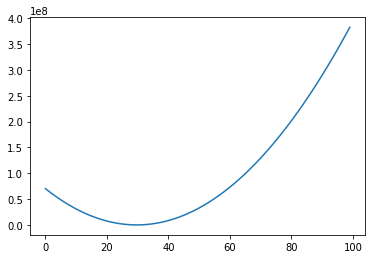

[[0.30303030303030304], [0.696969696969697]]


In [25]:
probabilities, MSE = optimise_probabilities(Y, counter_1, delays=[[5],[7]])

plt.plot(MSE)
plt.show()

print(probabilities)

Suppose that the flow from counter 1 can go to either counter 2 with delay 0 or to counter 7 with delay 1. We estimate theprobability of going south and west.

In [26]:
Y = np.array([counter_2, counter_7])
probabilities, MSE = optimise_probabilities(Y, counter_1, delays=[[0],[1]])

print(probabilities)

[[0.4040404040404041], [0.5959595959595959]]
